In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# définir les étiquettes attendues pour exclure une étiquette "ff"
expected_labels = {'stop', 'ceder', 'danger', 'forange', 'frouge', 'fvert', 'interdiction', 'obligation', 'unknown'}

# recadrer les régions d'intérêt et les étiqueter
def extract_region(image_path, csv_path):
    image = cv2.imread(image_path)
    regions = []

    # lire les régions d'intérêt à partir du fichier CSV
    try:
        data = pd.read_csv(csv_path, header=None)
        if data.empty:
            raise pd.errors.EmptyDataError
    except (pd.errors.EmptyDataError, FileNotFoundError):
        height, width = image.shape[:2]
        # si le fichier csv est vide, on considère que l'image entière est une région inconnue. Parce que cette image n'a pas de région d'intérêt.
        # !!!JE CONSEILLE DE COUPER PLUSIEURS REGIONS SANS ETIQUETTE POUR AVOIR UN ENTRAINEMENT PLUS ROBUSTE!!!
        regions = [(cv2.resize(image, (64, 64)), 'unknown')]
        return regions

    for index, row in data.iterrows():
        x1, y1, x2, y2, label = row
        label = label.strip().lower()  # qqn a mis des espaces avant et après les étiquettes et les a converties en minuscules
        if label not in expected_labels:
            print(f"Ignored unexpected label '{label}' found in file {csv_path}.")
            continue  # ignorer les étiquettes inattendues
        region = image[int(y1):int(y2), int(x1):int(x2)]
        if region.size == 0:
            continue
        region = cv2.resize(region, (64, 64))
        regions.append((region, label))
    return regions

# extraire les caractéristiques HOG
def extract_hog_features(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, hog_image = hog(image_gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    return features

# charger le jeu de données
def load_dataset(image_folder, label_folder):
    features = []
    labels = []
    for image_file in os.listdir(image_folder):
        if image_file.endswith('.jpg'):
            image_path = os.path.join(image_folder, image_file)
            csv_path = os.path.join(label_folder, image_file.replace('.jpg', '.csv'))
            regions = extract_region(image_path, csv_path)
            for region, label in regions:
                features.append(extract_hog_features(region))
                labels.append(label)
    return np.array(features), np.array(labels)

# définir les dossiers d'images et d'étiquettes
train_image_folder = './train/images'
train_label_folder = './train/labels'
val_image_folder = './val/images'
val_label_folder = './val/labels'

X_train, y_train = load_dataset(train_image_folder, train_label_folder)
X_val, y_val = load_dataset(val_image_folder, val_label_folder)

# vérifier si les données sont chargées correctement
print(f"Loaded {len(X_train)} training samples and {len(X_val)} validation samples.")

# convertir les étiquettes en nombres
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

# afficher les étiquettes et les nombres correspondants
print("les nombres et les étiquettes", le.classes_)

# PCA
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# entraîner le modèle SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_pca, y_train)

# évaluer le modèle (mtn sur les données de test, mais on doit aussi le faire sur les données de validation) De plus, ces tests sont basés sur les images coupées......
y_pred = svm_model.predict(X_val_pca)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

F:\anaconda3\envs\sy32\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Ignored unexpected label 'ff' found in file ./train/labels\0079.csv.
Ignored unexpected label 'ff' found in file ./train/labels\0079.csv.
Ignored unexpected label 'ff' found in file ./train/labels\0079.csv.
Ignored unexpected label 'ff' found in file ./train/labels\0085.csv.
Ignored unexpected label 'ff' found in file ./train/labels\0086.csv.
Ignored unexpected label 'ff' found in file ./train/labels\0086.csv.
Ignored unexpected label 'ff' found in file ./train/labels\0090.csv.
Ignored unexpected label 'ff' found in file ./train/labels\0090.csv.
Ignored unexpected label 'ff' found in file ./val/labels\0088.csv.
Loaded 1062 training samples and 118 validation samples.
标签与数字的对应关系： ['ceder' 'danger' 'forange' 'frouge' 'fvert' 'interdiction' 'obligation'
 'stop' 'unknown']
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        17
           1       0.94      1.00      0.97        16
           2       0.75      0.60      0.67         5
   

In [2]:
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])


In [3]:
def pyramid(image, scale=1.5, min_size=(30, 30)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        h = int(image.shape[0] / scale)
        image = cv2.resize(image, (w, h))
        if image.shape[0] < min_size[1] or image.shape[1] < min_size[0]:
            break
        yield image


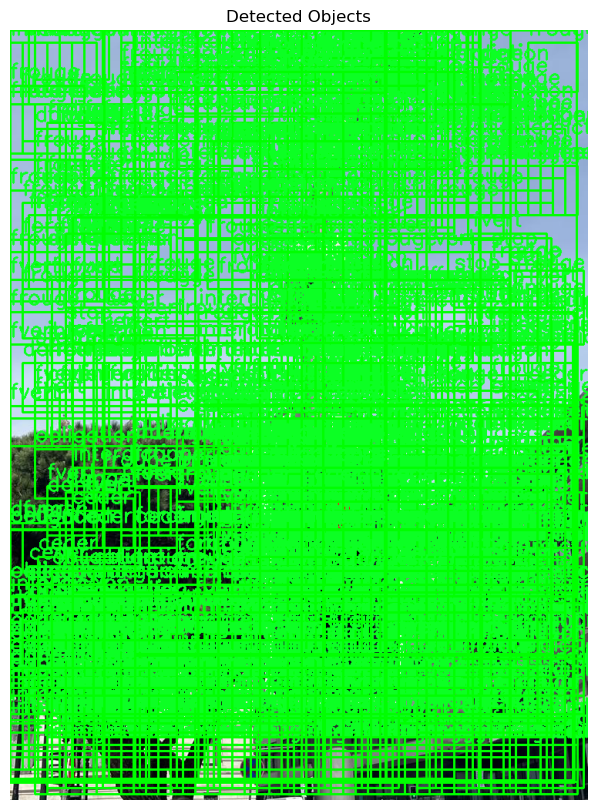

In [15]:
import matplotlib.pyplot as plt

def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def pyramid(image, scale=1.5, min_size=(30, 30)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        h = int(image.shape[0] / scale)
        image = cv2.resize(image, (w, h))
        if image.shape[0] < min_size[1] or image.shape[1] < min_size[0]:
            break
        yield image

def detect_objects(image, model, pca, window_size=(64, 64), step_size=16, pyramid_scale=1.5, threshold=0.5):
    detected_objects = []
    
    for resized in pyramid(image, scale=pyramid_scale):
        scale = image.shape[0] / float(resized.shape[0])
        
        for (x, y, window) in sliding_window(resized, step_size=step_size, window_size=window_size):
            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                continue
            
            features, _ = extract_hog_features(window)
            features_pca = pca.transform([features])
            decision_value = model.decision_function(features_pca)
            
            decision_value = decision_value.flatten()  # 将数组展平为一维
        
            if decision_value[0] > threshold:  # Use threshold for decision value
                prediction = model.predict(features_pca)
                if prediction[0] != len(expected_labels) - 1:  # Assuming 'unknown' is the last label
                    detected_objects.append((int(x * scale), int(y * scale), 
                                             int((x + window_size[0]) * scale), 
                                             int((y + window_size[1]) * scale), 
                                             prediction[0]))
    
    return detected_objects

# 加载和预处理测试图像
test_image_path = './val/images/0004.jpg'
test_image = cv2.imread(test_image_path)

# 确保图像加载正确
if test_image is None:
    print("图像加载失败，请检查路径：", test_image_path)
else:
    # 假设SVM模型、PCA模型和标签编码器已经训练好并命名为svm_model, pca, le
    detected_objects = detect_objects(test_image, svm_model, pca, threshold=0.5)

    # 显示检测结果
    for (x1, y1, x2, y2, label) in detected_objects:
        cv2.rectangle(test_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(test_image, le.inverse_transform([label])[0], (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # 将BGR图像转换为RGB图像以便matplotlib显示
    test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    # 使用matplotlib显示图像
    plt.figure(figsize=(10, 10))
    plt.imshow(test_image_rgb)
    plt.axis('off')
    plt.title("Detected Objects")
    plt.show()